# Overview of toposample classification results

In [1]:
import numpy as np
import h5py
import os

from toposample import Config, data
from matplotlib import pyplot as plt

"""
Main config file. This file specifies the paths to all the result files and allows us to read the results.
"""
# campaign_spec = ['4073e95f-abb1-4b86-8c38-13cf9f00ce0b', '_ABCD_']
campaign_spec = ['5b1420ca-dd31-4def-96d6-46fe99d20dcc', '_ABCD_']
# Path to the main configuration file. Available at the same location where you obtained this notebook
cfg = Config(f'/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/analyses/proj96/{campaign_spec[0]}/topological_sampling/working_dir{campaign_spec[1]}/config/common_config.json')

# Prepare save path
save_path = os.path.join('.', 'figures', ''.join(campaign_spec))
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [2]:
"""
LOADING THE DATA...
Location of relevant data is looked up from the main config file.
"""
# Looking up paths from the configuration. Available at the same location where you obtained this notebook,
# or by running the analysis pipeline on the input data.
components_fn = cfg._cfg['analyzed']['components']
acc_comp_fn = cfg._cfg['analyzed']['classifier_components_results']
acc_ftr_fn = cfg._cfg['analyzed']['classifier_features_results']
num_stimuli = cfg.stage("split_spikes")["config"]["num_stimuli"]
num_components = cfg.stage("manifold_analysis")["config"]["n_components"]


"""
Then we can load it.
"""
per_stim_read_fun = data.read_multiple_h5_datasets(dict([("stim{0}".format(i),
                                                          "per_stimulus/stim{0}".format(i))
                                                         for i in range(num_stimuli)]))
score_read_fun = data.read_h5_dataset("scores")
acc_comp_data = data.TopoData(acc_comp_fn,
                              follow_link_functions={"data_fn": [score_read_fun, True]})["data_fn"]
acc_ftr_data = data.TopoData(acc_ftr_fn,
                            follow_link_functions={"data_fn": [score_read_fun, True]})["data_fn"]

In [3]:
# Compute mean acc. over CV folds
def ordered_stack(x, y, out_fun=np.array, cast_int=False):
    if cast_int:
        x = list(map(int, x))
    idx = np.argsort(x)
    return out_fun([y[i] for i in idx])

mean_acc_comp = acc_comp_data.map(lambda x: np.nanmean(x)) # scalar; (sampling, specifier, index)
mean_acc_comp = mean_acc_comp.pool(['index'], func=lambda x, y: ordered_stack(x, y, cast_int=True), xy=True) # shape: index
mean_acc_ftr = acc_ftr_data.map(lambda x: np.nanmean(x)) # scalar; (sampling, specifier, index)
mean_acc_ftr = mean_acc_ftr.pool(['index'], func=lambda x, y: ordered_stack(x, y, cast_int=True), xy=True) # shape: index

Nothing to pool along ['index'].


In [4]:
# Plot accuracy overview
def plot_acc_overview(acc, sampling, chance_level=None, acc_lim=None, fig_size=None, name=None, save_fn=None):
    color_mean = 'tab:blue'
    color_std = 'tab:grey'
    color_single = 'k'
    color_chance = 'tab:red'
    bar_width = 0.8

    if not name:
        name = ''
    else:
        name = name + ': '

    acc_sel = acc.filter(sampling=sampling)
    specs = acc_sel.labels_of('specifier')

    np.random.seed(0)
    plt.figure(figsize=fig_size)
    for sidx, spec in enumerate(specs):
        acc_val = acc_sel.get2(specifier=spec)
        plt.bar(sidx, np.mean(acc_val), width=bar_width, color=color_mean)
        if len(acc_val) > 1:
            plt.plot(np.full(2, sidx), [np.mean(acc_val) - np.std(acc_val), np.mean(acc_val) + np.std(acc_val)], '_-', color=color_std, linewidth=2, markeredgewidth=2, markersize=10)
            plt.plot(sidx + (np.random.rand(len(acc_val)) - 0.5) * bar_width, acc_val, '.', color=color_single, markersize=1)
    plt.xlim([-0.5, len(specs) - 0.5]) # Freeze limits
    if chance_level:
        plt.plot(plt.xlim(), np.full(2, chance_level), '--', color=color_chance)
        plt.text(0.1 + np.max(plt.xlim()), chance_level, 'Chance level', ha='left', va='center', rotation=90, color=color_chance)
    if acc_lim:
        plt.ylim(acc_lim)
    plt.xticks(np.arange(len(specs)), specs, rotation=45, ha='right')
    plt.title(f'{name}{sampling} sampling', fontweight='bold')
    plt.ylabel('Accuracy')
    plt.gca().set_axisbelow(True)
    plt.grid(axis='y')
    plt.tight_layout()
    if save_fn:
        plt.savefig(save_fn, dpi=300)

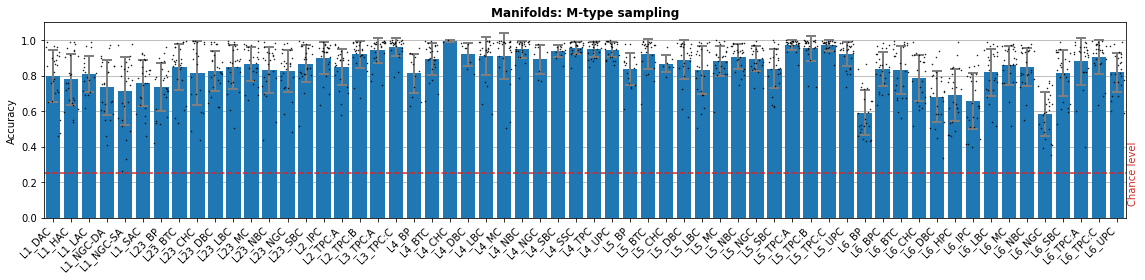

In [5]:
acc_lim = [0, 1.1]
plot_acc_overview(mean_acc_comp, 'M-type', chance_level=1 / num_stimuli, acc_lim=acc_lim, fig_size=(16, 4), name='Manifolds', save_fn=os.path.join(save_path, 'AccOverview_Manifolds_MTypeSampling.png'))

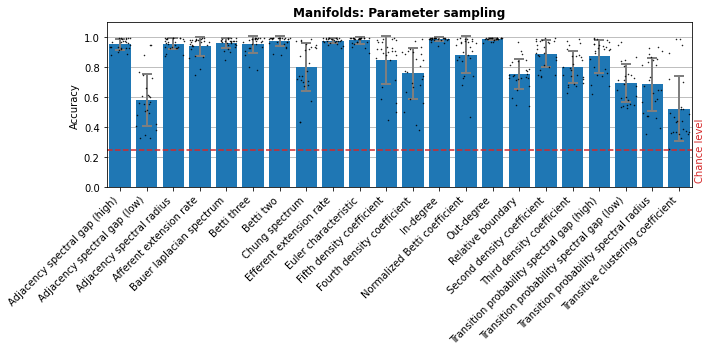

In [6]:
plot_acc_overview(mean_acc_comp, 'Parameter', chance_level=1 / num_stimuli, acc_lim=acc_lim, fig_size=(10, 5), name='Manifolds', save_fn=os.path.join(save_path, 'AccOverview_Manifolds_ParameterSampling.png'))

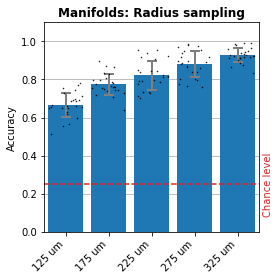

In [7]:
plot_acc_overview(mean_acc_comp, 'Radius', chance_level=1 / num_stimuli, acc_lim=acc_lim, fig_size=(4, 4), name='Manifolds', save_fn=os.path.join(save_path, 'AccOverview_Manifolds_RadiusSampling.png'))

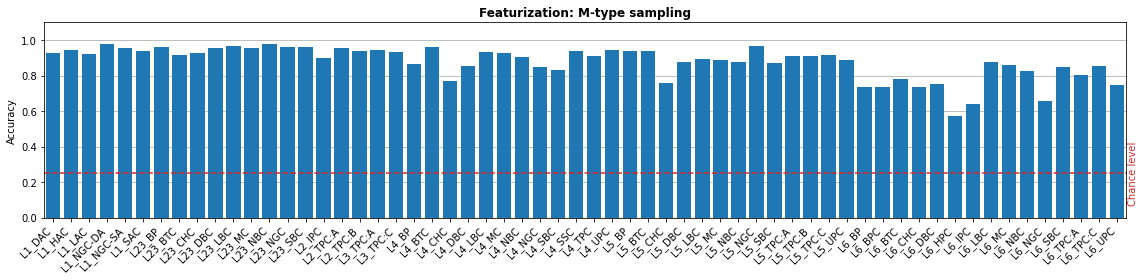

In [8]:
plot_acc_overview(mean_acc_ftr, 'M-type', chance_level=1 / num_stimuli, acc_lim=acc_lim, fig_size=(16, 4), name='Featurization', save_fn=os.path.join(save_path, 'AccOverview_Featurization_MTypeSampling.png'))

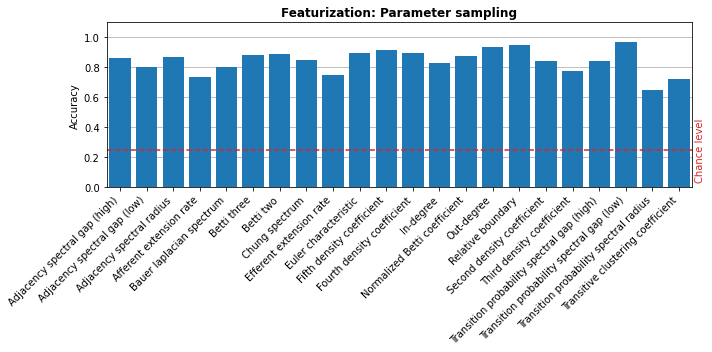

In [9]:
plot_acc_overview(mean_acc_ftr, 'Parameter', chance_level=1 / num_stimuli, acc_lim=acc_lim, fig_size=(10, 5), name='Featurization', save_fn=os.path.join(save_path, 'AccOverview_Featurization_ParameterSampling.png'))

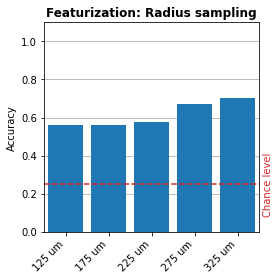

In [10]:
plot_acc_overview(mean_acc_ftr, 'Radius', chance_level=1 / num_stimuli, acc_lim=acc_lim, fig_size=(4, 4), name='Featurization', save_fn=os.path.join(save_path, 'AccOverview_Featurization_RadiusSampling.png'))